In [1]:
# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp


In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
list_sub = ["ccpd_weather"]
BASE_PATH = "C:/Users/User/DeepLearning/Deep_Learning/final_project"

In [3]:
file = "C:/Users/User/DeepLearning/Deep_Learning/final_project/ccpd_base/01-89_84-231,482_413,539-422,537_242,536_219,475_399,476-0_0_15_11_25_26_26-121-16.jpg"

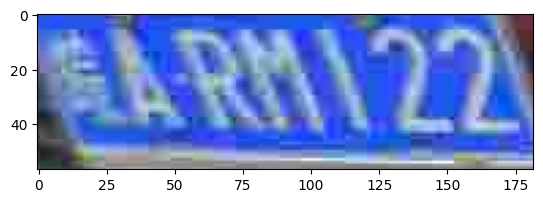

In [4]:
file_no_jpg = file.split("/")[-1][:-4]
boundind_box = file_no_jpg.split("-")[2]
left_up_bbox = boundind_box.split("_")[0]
right_down_bbox = boundind_box.split("_")[1]

x1 = int(left_up_bbox.split(",")[0])
y1 = int(left_up_bbox.split(",")[1])
x2 = int(right_down_bbox.split(",")[0])
y2 = int(right_down_bbox.split(",")[1])

ori_image = cv2.imread(file)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
roi = ori_image[y1:y2, x1:x2]

plt.imshow(roi)
plt.show()

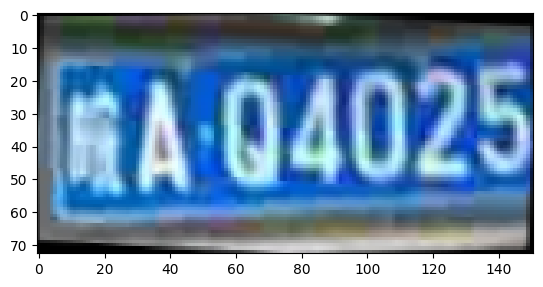

In [45]:
horizontal_angle = int(file_no_jpg.split("-")[1].split("_")[0])
vertical_angle = int(file_no_jpg.split("-")[1].split("_")[1])
horizontal_rotation_matrix = cv2.getRotationMatrix2D((roi.shape[1] // 2, roi.shape[0] // 2), horizontal_angle - 90, 1)
vertical_rotation_matrix = cv2.getRotationMatrix2D((roi.shape[1] // 2, roi.shape[0] // 2), vertical_angle - 90, 1)

# 旋转图像
horizontal_rotated_image = cv2.warpAffine(roi, horizontal_rotation_matrix, (roi.shape[1], roi.shape[0]))
rotated_image = cv2.warpAffine(horizontal_rotated_image, vertical_rotation_matrix, (roi.shape[1], roi.shape[0]))

# plt.imshow(roi)
plt.imshow(rotated_image)
# plt.imshow(vertical_rotated_image)
plt.show()

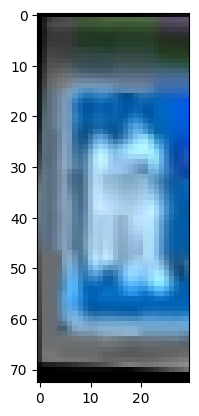

In [59]:
boundind_box = file_no_jpg.split("-")[2]
left_up_bbox = boundind_box.split("_")[0]
right_down_bbox = boundind_box.split("_")[1]
width = int(right_down_bbox.split(",")[0])-int(left_up_bbox.split(",")[0])

chinese_img = rotated_image[:,:width//5]
plt.imshow(chinese_img)
# plt.imshow(vertical_rotated_image)
plt.show()

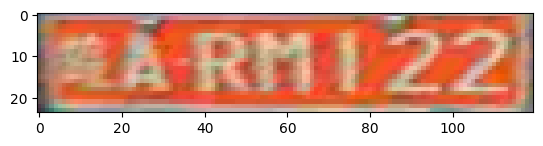

In [5]:
exver_img = cv2.imread(file)
vertices = file_no_jpg.split("-")[3]
split = vertices.split("_")

x= (split[0].split(','))
y= (split[1].split(','))
z= (split[2].split(','))
w= (split[3].split(','))
coordinates= [int(x[0]), int(x[1]),int(y[0]),int(y[1]),int(z[0]),int(z[1]),int(w[0]),int(w[1])]

p1 = np.float32([[coordinates[4], coordinates[5]],
                [coordinates[6], coordinates[7]],
                [coordinates[2], coordinates[3]], 
                [coordinates[0], coordinates[1]]])
p2 = np.float32([[0, 0],[exver_img.shape[1],0],[0,exver_img.shape[0]],[exver_img.shape[1],exver_img.shape[0]]])
M = cv2.getPerspectiveTransform(p1, p2)
outimg = cv2.warpPerspective(exver_img, M, exver_img.shape[1::-1])
resized = cv2.resize(outimg, (120,24), interpolation = cv2.INTER_AREA)
plt.imshow(resized)
# plt.imshow(vertical_rotated_image)
plt.show()

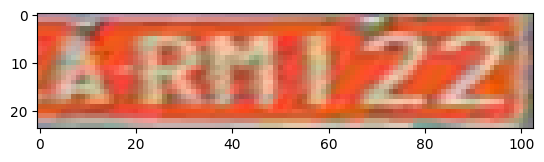

In [8]:
chinese_img = resized[:,120//7:]
plt.imshow(chinese_img)
# plt.imshow(vertical_rotated_image)
plt.show()

In [4]:
chinese_img = resized[:,:120//8]
plt.imshow(chinese_img)
# plt.imshow(vertical_rotated_image)
plt.show()

NameError: name 'resized' is not defined

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:50]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Store bounding box information for the first character
    first_char_bbox = None

    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of the rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x-coordinate of the character's contour

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Store bounding box information for the first character
            if first_char_bbox is None:
                first_char_bbox = (intX, intY, intWidth, intHeight)
            
            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.bitwise_not(char)

            # Resize the image to 24x44 with a black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    plt.show()
    # arbitrary function that stores a sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res, first_char_bbox

# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 6, LP_WIDTH / 2, LP_HEIGHT / 10, 2 * LP_HEIGHT / 3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list, first_char_bbox = find_contours(dimensions, img_binary_lp)

    return char_list, first_char_bbox

# Example usage



char_list, first_char_bbox = segment_characters(rotated_image)

# Output the left-up vertex of the bounding box for the first character
if first_char_bbox is not None:
    print("Left-up vertex of the bounding box for the first character:", (first_char_bbox[0], first_char_bbox[1]))


NameError: name 'rotated_image' is not defined

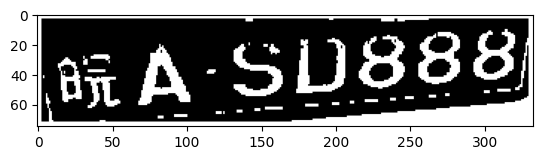

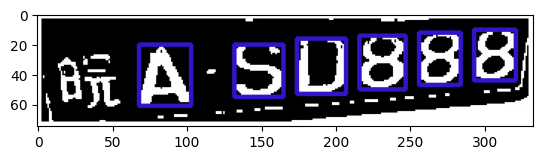

In [108]:
char = segment_characters(roi)

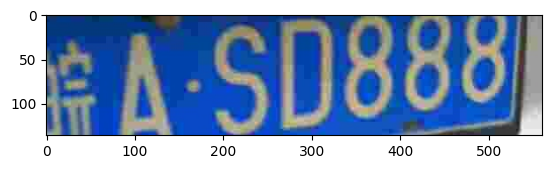

In [48]:
exver_img = cv2.imread(file)
exver_img = cv2.cvtColor(exver_img, cv2.COLOR_BGR2RGB)
vertices = file_no_jpg.split("-")[3]
vertices_split = vertices.split("_")

x1, y1 = list(map(int, vertices_split[2].split(",")))
x2, y2 = list(map(int, vertices_split[0].split(",")))
ex_img = exver_img[y1:y2, x1:x2]


plt.imshow(ex_img)
plt.show()

In [4]:
img_path = []
left_up_x = []
left_up_y = []
right_down_x = []
right_down_y = []
decoded_plate = []
location = []
license_images = []
for sub in list_sub:
    sub_path = os.path.join(BASE_PATH, sub)
    sub_files = glob.glob(os.path.join(sub_path, "*"))

    for file in sub_files:

        img_path.append(file)

        file_no_jpg = file.split("/")[-1][:-4]

        boundind_box = file_no_jpg.split("-")[2]
        left_up_bbox = boundind_box.split("_")[0]
        right_down_bbox = boundind_box.split("_")[1]
        left_up_x .append(left_up_bbox.split(",")[0])
        left_up_y .append(left_up_bbox.split(",")[1])
        right_down_x .append(right_down_bbox.split(",")[0])
        right_down_y .append(right_down_bbox.split(",")[1])



        temp = []
        plate_number =  file_no_jpg.split("-")[-3]
        plate_number_split =  plate_number.split('_')
        city = provinces[int(plate_number_split[0])]
        alp = alphabets[int(plate_number_split[1])]
        # temp.append(city)
        temp.append(alp)
        
        for i in range(len(plate_number_split)-2):
            temp.append(ads[int(plate_number_split[i+2])])
        k = "".join(temp)
        decoded_plate.append(k)


        # exver_img = cv2.imread(file)
        # vertices = file_no_jpg.split("-")[3]
        # split = vertices.split("_")

        # x= (split[0].split(','))
        # y= (split[1].split(','))
        # z= (split[2].split(','))
        # w= (split[3].split(','))
        # coordinates= [int(x[0]), int(x[1]),int(y[0]),int(y[1]),int(z[0]),int(z[1]),int(w[0]),int(w[1])]
        # location.append(coordinates)
        # p1 = np.float32([[coordinates[4], coordinates[5]],
        #                 [coordinates[6], coordinates[7]],
        #                 [coordinates[2], coordinates[3]], 
        #                 [coordinates[0], coordinates[1]]])
        # p2 = np.float32([[0, 0],[exver_img.shape[1],0],[0,exver_img.shape[0]],[exver_img.shape[1],exver_img.shape[0]]])
        # M = cv2.getPerspectiveTransform(p1, p2)
        # outimg = cv2.warpPerspective(exver_img, M, exver_img.shape[1::-1])
        # resized = cv2.resize(outimg, (120,24), interpolation = cv2.INTER_AREA)
        # no_chinese_img = resized[:,width//8:]
        # license_images.append(resized)
        


        

r = [img_path,left_up_x,left_up_y,right_down_x,right_down_y,decoded_plate]
all_data = pd.DataFrame(r)
all_data = all_data.T
all_data.columns = ['img_path','x1','y1','x2','y2','decode_plate']
all_data                

,img_path,x1,y1,x2,y2,decode_plate
0,C:/Users/User/DeepLearning/Deep_Learning/final...,294,496,374,540,AD130W
1,C:/Users/User/DeepLearning/Deep_Learning/final...,304,542,411,577,AUT267
2,C:/Users/User/DeepLearning/Deep_Learning/final...,339,547,444,583,MZ4882
3,C:/Users/User/DeepLearning/Deep_Learning/final...,177,511,268,553,AVD028
4,C:/Users/User/DeepLearning/Deep_Learning/final...,402,426,497,467,RL222P
...,...,...,...,...,...,...
9994,C:/Users/User/DeepLearning/Deep_Learning/final...,89,832,500,1159,AK927W
9995,C:/Users/User/DeepLearning/Deep_Learning/final...,81,357,572,632,A22T99
9996,C:/Users/User/DeepLearning/Deep_Learning/final...,245,391,703,692,NRX399
9997,C:/Users/User/DeepLearning/Deep_Learning/final...,69,394,681,620,EW666K


In [5]:
list_split = ["train"] * 9499
for i in range(5):
    list_split.extend(["val"]*50)
    list_split.extend(["test"]*50)
all_data ["split"] = list_split
all_data 

,img_path,x1,y1,x2,y2,decode_plate,split
0,C:/Users/User/DeepLearning/Deep_Learning/final...,294,496,374,540,AD130W,train
1,C:/Users/User/DeepLearning/Deep_Learning/final...,304,542,411,577,AUT267,train
2,C:/Users/User/DeepLearning/Deep_Learning/final...,339,547,444,583,MZ4882,train
3,C:/Users/User/DeepLearning/Deep_Learning/final...,177,511,268,553,AVD028,train
4,C:/Users/User/DeepLearning/Deep_Learning/final...,402,426,497,467,RL222P,train
...,...,...,...,...,...,...,...
9994,C:/Users/User/DeepLearning/Deep_Learning/final...,89,832,500,1159,AK927W,test
9995,C:/Users/User/DeepLearning/Deep_Learning/final...,81,357,572,632,A22T99,test
9996,C:/Users/User/DeepLearning/Deep_Learning/final...,245,391,703,692,NRX399,test
9997,C:/Users/User/DeepLearning/Deep_Learning/final...,69,394,681,620,EW666K,test


In [6]:
df_train = all_data [all_data["split"]=="train"].reset_index(drop=True)
df_train = df_train[["img_path", "x1", "y1", "x2", "y2","decode_plate"]]
df_train

,img_path,x1,y1,x2,y2,decode_plate
0,C:/Users/User/DeepLearning/Deep_Learning/final...,294,496,374,540,AD130W
1,C:/Users/User/DeepLearning/Deep_Learning/final...,304,542,411,577,AUT267
2,C:/Users/User/DeepLearning/Deep_Learning/final...,339,547,444,583,MZ4882
3,C:/Users/User/DeepLearning/Deep_Learning/final...,177,511,268,553,AVD028
4,C:/Users/User/DeepLearning/Deep_Learning/final...,402,426,497,467,RL222P
...,...,...,...,...,...,...
9494,C:/Users/User/DeepLearning/Deep_Learning/final...,179,440,595,575,AR8647
9495,C:/Users/User/DeepLearning/Deep_Learning/final...,190,506,572,653,A47039
9496,C:/Users/User/DeepLearning/Deep_Learning/final...,125,405,526,545,A4U877
9497,C:/Users/User/DeepLearning/Deep_Learning/final...,290,482,680,626,AH790W


In [7]:
df_val = all_data [all_data["split"]=="val"].reset_index(drop=True)
df_val = df_val[["img_path", "x1", "y1", "x2", "y2","decode_plate"]]
df_val

,img_path,x1,y1,x2,y2,decode_plate
0,C:/Users/User/DeepLearning/Deep_Learning/final...,217,448,475,666,AY6F46
1,C:/Users/User/DeepLearning/Deep_Learning/final...,134,424,504,576,C096FU
2,C:/Users/User/DeepLearning/Deep_Learning/final...,54,394,380,567,C0C9U1
3,C:/Users/User/DeepLearning/Deep_Learning/final...,281,536,662,684,AY060V
4,C:/Users/User/DeepLearning/Deep_Learning/final...,162,445,586,578,ADB398
...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,147,426,643,595,AL1U67
246,C:/Users/User/DeepLearning/Deep_Learning/final...,199,362,533,613,AUL132
247,C:/Users/User/DeepLearning/Deep_Learning/final...,233,338,589,574,AFJ956
248,C:/Users/User/DeepLearning/Deep_Learning/final...,94,424,601,592,AS661Z


In [8]:
from numba import cuda
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% |  2% |


In [1]:
resnet = resnet18(pretrained=True)

NameError: name 'torch' is not defined

In [3]:

class Dataset(Dataset):
    def __init__(self, dataframe):
        self.df_train = dataframe

    def __len__(self):
        return len(self.df_train)

    def __getitem__(self, index):
        train_path = self.df_train["img_path"][index]
        file_no_jpg = train_path.split("/")[-1][:-4]

        exver_img = cv2.imread(train_path)
        vertices = file_no_jpg.split("-")[3]
        split = vertices.split("_")

        x= (split[0].split(','))
        y= (split[1].split(','))
        z= (split[2].split(','))
        w= (split[3].split(','))
        coordinates= [int(x[0]), int(x[1]),int(y[0]),int(y[1]),int(z[0]),int(z[1]),int(w[0]),int(w[1])]
        location.append(coordinates)
        p1 = np.float32([[coordinates[4], coordinates[5]],
                        [coordinates[6], coordinates[7]],
                        [coordinates[2], coordinates[3]], 
                        [coordinates[0], coordinates[1]]])
        p2 = np.float32([[0, 0],[exver_img.shape[1],0],[0,exver_img.shape[0]],[exver_img.shape[1],exver_img.shape[0]]])
        M = cv2.getPerspectiveTransform(p1, p2)
        outimg = cv2.warpPerspective(exver_img, M, exver_img.shape[1::-1])
        resized = cv2.resize(outimg, (120,24), interpolation = cv2.INTER_AREA)
        
        no_chinese_img = resized[:,120//8:]

        text = self.df_train["decode_plate"][index]

        # Apply transformations
        transformed_image = self.transform(no_chinese_img)

        return transformed_image, text

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((50, 200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

NameError: name 'Dataset' is not defined

In [84]:
trainset = Dataset(df_train)
valset =  Dataset(df_val)

train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
test_loader = DataLoader(valset, batch_size=16, num_workers=0, shuffle=False)
print(len(train_loader))

594


In [85]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([16, 3, 24, 105]) ('AD130W', 'AUT267', 'MZ4882', 'AVD028', 'RL222P', 'AGC276', 'AU0194', 'AC880Y', 'ATG568', 'A41476', 'AH8V95', 'ATV235', 'AJ7532', 'AE0901', 'QSW808', 'A93853')


In [86]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O','0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
idx2char = {k:v for k,v in enumerate(alphabets, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'J', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'U', 19: 'V', 20: 'W', 21: 'X', 22: 'Y', 23: 'Z', 24: 'O', 25: '0', 26: '1', 27: '2', 28: '3', 29: '4', 30: '5', 31: '6', 32: '7', 33: '8', 34: '9'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'J': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23, 'O': 24, '0': 25, '1': 26, '2': 27, '3': 28, '4': 29, '5': 30, '6': 31, '7': 32, '8': 33, '9': 34}


In [87]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

35


In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.4):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch
        
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)            

cuda


In [103]:
class ModifiedCRNN(nn.Module):
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.4):
        super(ModifiedCRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        # CNN
        resnet = resnet18(pretrained=True)
        resnet_modules = list(resnet.children())[:-2]
        self.cnn = nn.Sequential(*resnet_modules)
        self.conv = nn.Conv2d(512, 256, kernel_size=(1, 3), stride=(1, 2), padding=(0, 0))  # Adjusted kernel_size
        self.batch_norm = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)

        # Linear layers
        self.linear1 = nn.Linear(256, 256)  # Adjusted input size
        self.linear2 = nn.Linear(rnn_hidden_size, num_chars)

        # Bidirectional GRU
        self.rnn = nn.GRU(input_size=256, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)

    def forward(self, batch):
        batch = self.cnn(batch)
        print(batch.shape)
        batch = self.conv(batch)
        print(batch.shape)
        batch = self.batch_norm(batch)
        print(batch.shape)
        batch = self.relu(batch)
        print(batch.shape)

        batch = batch.permute(0, 3, 1, 2)
        print(batch.shape)
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1)
        print(batch.shape) 

        batch = self.linear1(batch)
        print(batch.shape)

        batch, _ = self.rnn(batch)
        print(batch.shape)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size // 2] + batch[:, :, feature_size // 2:]
        print(batch.shape)

        batch = self.linear2(batch)
        print(batch.shape)
        batch = batch.permute(1, 0, 2)
        print(batch.shape)

        return batch

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

modified_crnn = ModifiedCRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
modified_crnn.apply(weights_init)
modified_crnn = modified_crnn.to(device)

In [91]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

RuntimeError: Calculated padded input size per channel: (1 x 4). Kernel size: (1 x 6). Kernel size can't be greater than actual input size

In [41]:
criterion = nn.CTCLoss(blank=0)

In [42]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

compute_loss(text_batch, text_batch_logits)

tensor(4.7854, device='cuda:0', grad_fn=<MeanBackward0>)

In [43]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [44]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:1    Loss:1.8509089924671032    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:2    Loss:1.552863851139441    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:3    Loss:1.5247369516979565    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:4    Loss:1.5054831657345447    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:5    Loss:1.4898586564192466    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:6    Loss:1.47472763362557    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:7    Loss:1.4697109555154537    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:8    Loss:1.4664593842695859    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:9    Loss:1.461838748318579    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:10    Loss:1.4549970923850832    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:11    Loss:1.453442177587888    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:12    Loss:1.4464571682692378    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:13    Loss:1.4471325938549107    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:14    Loss:1.4433234530667263    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:15    Loss:1.4406894577874079    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:16    Loss:1.439378731379204    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:17    Loss:1.4355922883207148    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:18    Loss:1.4351714319652982    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:19    Loss:1.4348456574610187    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:20    Loss:1.4343817527045304    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:21    Loss:1.4298547941827613    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:22    Loss:1.4309851768040898    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:23    Loss:1.4312872023694845    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:24    Loss:1.4262085785769454    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:25    Loss:1.4260829020830919    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:26    Loss:1.4303164417896206    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:27    Loss:1.4298416410231027    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:28    Loss:1.427546987027833    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:29    Loss:1.4274114360311618    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:30    Loss:1.4276350618211509    NumUpdates:594
Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:31    Loss:1.3590386246992683    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:32    Loss:1.340576091800073    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:33    Loss:1.3371220072511871    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:34    Loss:1.3360782068987889    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:35    Loss:1.3358194824019667    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:36    Loss:1.335592473396147    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:37    Loss:1.335264720900693    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:38    Loss:1.33573416166434    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:39    Loss:1.3358236978752445    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:40    Loss:1.3356605130012589    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:41    Loss:1.336142887972822    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:42    Loss:1.3359217649758464    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:43    Loss:1.3367679998128101    NumUpdates:594
Epoch 00043: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:44    Loss:1.329246345393184    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:45    Loss:1.3273155034993234    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:46    Loss:1.3278580669200781    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:47    Loss:1.3284441589907765    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:48    Loss:1.3289563276550986    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:49    Loss:1.3293396372987767    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:50    Loss:1.3297145796143246    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:51    Loss:1.3300410820177508    NumUpdates:594
Epoch 00051: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:52    Loss:1.3301024942687063    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:53    Loss:1.3297924138480164    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:54    Loss:1.3297754403717992    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:55    Loss:1.3297937604714725    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:56    Loss:1.3298100359512097    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:57    Loss:1.3298307785682806    NumUpdates:594
Epoch 00057: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:58    Loss:1.3298169490865586    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:59    Loss:1.3297976781222154    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:60    Loss:1.3297909722986445    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:61    Loss:1.3297891095029786    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:62    Loss:1.3297952580130863    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:63    Loss:1.329803208510081    NumUpdates:594
Epoch 00063: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:64    Loss:1.329791010228873    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:65    Loss:1.3297927993716616    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:66    Loss:1.3297928543604585    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:67    Loss:1.3297964153867778    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:68    Loss:1.3297937566583806    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:69    Loss:1.3297955797176169    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:70    Loss:1.329795241155207    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:71    Loss:1.3297950139752142    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:72    Loss:1.3297934323448926    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:73    Loss:1.3297953410983487    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:74    Loss:1.3297924790719542    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:75    Loss:1.3297914822494943    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:76    Loss:1.3297944347866457    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:77    Loss:1.3297960330741574    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:78    Loss:1.32979750372344    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:79    Loss:1.3298015602509983    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:80    Loss:1.3298042019208272    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:81    Loss:1.3298022536316303    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:82    Loss:1.3298044764634334    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:83    Loss:1.329802403947721    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:84    Loss:1.3298057877656184    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:85    Loss:1.3298118560001104    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:86    Loss:1.3298102334292248    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:87    Loss:1.3298113488589072    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:88    Loss:1.3298133695968475    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:89    Loss:1.329812674811392    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:90    Loss:1.3298145299808746    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:91    Loss:1.3298128831266152    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:92    Loss:1.3298114732861117    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:93    Loss:1.3298131685064296    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:94    Loss:1.3298164387343308    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:95    Loss:1.3298163576559587    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:96    Loss:1.3298164220771405    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:97    Loss:1.329814451110082    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:98    Loss:1.3298142351686755    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:99    Loss:1.329813737058479    NumUpdates:594


  0%|          | 0/594 [00:00<?, ?it/s]

Epoch:100    Loss:1.3298161401090398    NumUpdates:594


In [11]:
from cnocr import CnOcr

def get_text_cnocr(idx):
   
    
    
    
    


    val_path = df_val["img_path"][idx]
    exver_img = cv2.imread(val_path)
    exver_img = cv2.cvtColor(exver_img, cv2.COLOR_BGR2RGB)
    cnocr_model = CnOcr()
    text_list = []



    file_no_jpg = val_path.split("/")[-1][:-4]
    vertices = file_no_jpg.split("-")[3]
    split = vertices.split("_")

    x= (split[0].split(','))
    y= (split[1].split(','))
    z= (split[2].split(','))
    w= (split[3].split(','))
    coordinates= [int(x[0]), int(x[1]),int(y[0]),int(y[1]),int(z[0]),int(z[1]),int(w[0]),int(w[1])]
    location.append(coordinates)
    p1 = np.float32([[coordinates[4], coordinates[5]],
                    [coordinates[6], coordinates[7]],
                    [coordinates[2], coordinates[3]], 
                    [coordinates[0], coordinates[1]]])
    p2 = np.float32([[0, 0],[exver_img.shape[1],0],[0,exver_img.shape[0]],[exver_img.shape[1],exver_img.shape[0]]])
    M = cv2.getPerspectiveTransform(p1, p2)
    outimg = cv2.warpPerspective(exver_img, M, exver_img.shape[1::-1])
    resized = cv2.resize(outimg, (120,24), interpolation = cv2.INTER_AREA)
    
    no_chinese_img = resized[:,120//8:]

    # text = df_train["decode_plate"][idx]
    text_output = cnocr_model.ocr(no_chinese_img)

    if(len(text_output)>0):
        text = text_output[0]["text"]
        
        # Clean Text
        del_punc_list = [" ", "·", ":", "-"]
        clean_text = re.sub(r"[ ·:-]", "", text)
        clean_text = clean_text.replace("O", "0")
        clean_text = clean_text.replace("I", "1")
        clean_text = clean_text.upper()
        text_list.append(clean_text)
        
        # Extract Plate Number
        
        
            
    return text_list

In [12]:
idxs = list(np.arange(0, 250))
text_results = tqdm([get_text_cnocr(idx) for idx in idxs])
text_results = [text[0] if len(text)>0 else "" for text in text_results]
df_val["pred_plate_number"] = text_results
df_val

  0%|          | 0/250 [00:00<?, ?it/s]

,img_path,x1,y1,x2,y2,decode_plate,pred_plate_number
0,C:/Users/User/DeepLearning/Deep_Learning/final...,217,448,475,666,AY6F46,Y6F46
1,C:/Users/User/DeepLearning/Deep_Learning/final...,134,424,504,576,C096FU,096F1
2,C:/Users/User/DeepLearning/Deep_Learning/final...,54,394,380,567,C0C9U1,C0C9U1
3,C:/Users/User/DeepLearning/Deep_Learning/final...,281,536,662,684,AY060V,AY060V
4,C:/Users/User/DeepLearning/Deep_Learning/final...,162,445,586,578,ADB398,ADB398
...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,147,426,643,595,AL1U67,AL1U67
246,C:/Users/User/DeepLearning/Deep_Learning/final...,199,362,533,613,AUL132,AUL132
247,C:/Users/User/DeepLearning/Deep_Learning/final...,233,338,589,574,AFJ956,AFJ956
248,C:/Users/User/DeepLearning/Deep_Learning/final...,94,424,601,592,AS661Z,AS661Z


In [13]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(df_val["decode_plate"], df_val['pred_plate_number'])
print(test_accuracy)

0.684


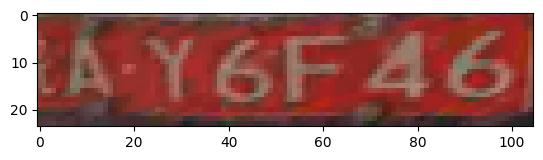

In [65]:
import pytesseract

val_path = df_val["img_path"][0]
exver_img = cv2.imread(val_path)



file_no_jpg = val_path.split("/")[-1][:-4]
vertices = file_no_jpg.split("-")[3]
split = vertices.split("_")

x= (split[0].split(','))
y= (split[1].split(','))
z= (split[2].split(','))
w= (split[3].split(','))
coordinates= [int(x[0]), int(x[1]),int(y[0]),int(y[1]),int(z[0]),int(z[1]),int(w[0]),int(w[1])]
location.append(coordinates)
p1 = np.float32([[coordinates[4], coordinates[5]],
                [coordinates[6], coordinates[7]],
                [coordinates[2], coordinates[3]], 
                [coordinates[0], coordinates[1]]])
p2 = np.float32([[0, 0],[exver_img.shape[1],0],[0,exver_img.shape[0]],[exver_img.shape[1],exver_img.shape[0]]])
M = cv2.getPerspectiveTransform(p1, p2)
outimg = cv2.warpPerspective(exver_img, M, exver_img.shape[1::-1])
resized = cv2.resize(outimg, (120,24), interpolation = cv2.INTER_AREA)


# img_gray_lp = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
# _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
# img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

# img_binary_lp[0:3, :] = 255
# img_binary_lp[:, 0:3] = 255
# img_binary_lp[72:75, :] = 255
# img_binary_lp[:, 330:333] = 255

# img_binary_lp = cv2.bitwise_not(img_binary_lp)



no_chinese_img = resized[:,120//8:]
plt.imshow(no_chinese_img, cmap='gray')



plt.show()


#img.show()
print(pytesseract.image_to_string(no_chinese_img, lang="eng"))


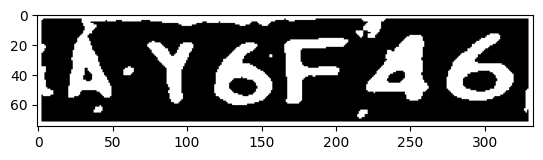

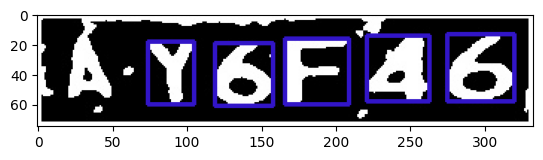

Left-up vertex of the bounding box for the first character: (275, 13)


In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:50]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Store bounding box information for the first character
    first_char_bbox = None

    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of the rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x-coordinate of the character's contour

            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Store bounding box information for the first character
            if first_char_bbox is None:
                first_char_bbox = (intX, intY, intWidth, intHeight)
            
            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.bitwise_not(char)

            # Resize the image to 24x44 with a black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    plt.show()
    # arbitrary function that stores a sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res, first_char_bbox

# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH / 6, LP_WIDTH , LP_HEIGHT / 15,LP_HEIGHT/2]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list, first_char_bbox = find_contours(dimensions, img_binary_lp)

    return char_list, first_char_bbox

# Example usage



char_list, first_char_bbox = segment_characters(no_chinese_img)

# Output the left-up vertex of the bounding box for the first character
if first_char_bbox is not None:
    print("Left-up vertex of the bounding box for the first character:", (first_char_bbox[0], first_char_bbox[1]))
